In [106]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd

import src.cfg as cfg
import src.data as data
import src.models as models
import src.processing as processing
import src.filters as fltr

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams["date.autoformatter.year"] = "%Y"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.style.use('seaborn-whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
def coords_to_point(coords):
    from src.utils import MyNetCDF
    ncdf = MyNetCDF(path='../data/meta/land-exapmle-int.nc')
    return list(ncdf.coords_to_index(coords)[0].data)

def plotting(pred, y_test, model_data, years_test,title=None):
    
    # plotting settings

    fig, ax = plt.subplots()
    plt.gca().xaxis.grid(True, linestyle='--')
    
    dates = pd.date_range('01/01/{}'.format(years_test[0]), '31/12/{}'.format(years_test[-1])).to_pydatetime()

    ax.plot(dates, pred, label='Predictions')
    ax.plot(dates, y_test, label='Measurements',linewidth=2)
    ax.plot(dates, model_data, label = 'NEMO', alpha=0.8)
    
    ax.axhline(y=0, color='grey', linestyle='-')
    fig.legend()
    fig.autofmt_xdate()

    if title is not None: plt.title(title)
    plt.show()
    return plt

In [214]:
parameters = dict(years_train=list(range(2010, 2014)),
                  years_test=[2014,2015],
                  X_vars=['ice_conc','icethic_cea', 'tair','vosaline','radlw'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[20, 20]
                  )

reg_params = dict(model='lasso',
                  dx=5,
                  dy=5,
                  dt=5
                  )
filters = dict(partial_pca=5)
points = [[78,84],[80,-5],[73.6,162],[85,-180]]
point = coords_to_point(points[2])

model_data = data.load_variable_years('icethic_cea', parameters['years_test'], point)
y_true =data.load_variable_years(parameters['y_var'], parameters['years_test'], point)


In [168]:
y_arr_train, X_arr_train = data.load_features(parameters['y_var'],
                                              parameters['X_vars'],
                                              parameters['years_train'])

y_arr_test, X_arr_test = data.load_features(parameters['y_var'],
                                            parameters['X_vars'],
                                            parameters['years_test'])
mask = np.load(cfg.mask_path)

ft = fltr.FeatureTable(dx=reg_params['dx'],
                       dy=reg_params['dy'],
                       dt=reg_params['dt'])

In [216]:
X_train = ft.gen_matrix(data=X_arr_train, x=point[0], y=point[1], filters=filters)
X_test = ft.gen_matrix(data=X_arr_test, x=point[0], y=point[1], filters=filters)

y_train = y_arr_train[:, point[0], point[1]]
y_test = y_arr_test[:, point[0], point[1]]

# plotting(res, y_test, model_data, parameters['years_test'], title = '{}N {}E'.format(point[0], point[1]))

In [217]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1461, 25) (730, 25) (1461,) (730,)


In [218]:
pred_out = np.empty_like(y_test)

y_train, X_train = models.clean_data(X=X_train, y=y_train)

mask = ~np.isnan(X_test).any(axis=1)
X_test = X_test[mask]
y_test = y_test[mask]

In [219]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_true.shape)

(494, 25) (708, 25) (494,) (708,) (730,)


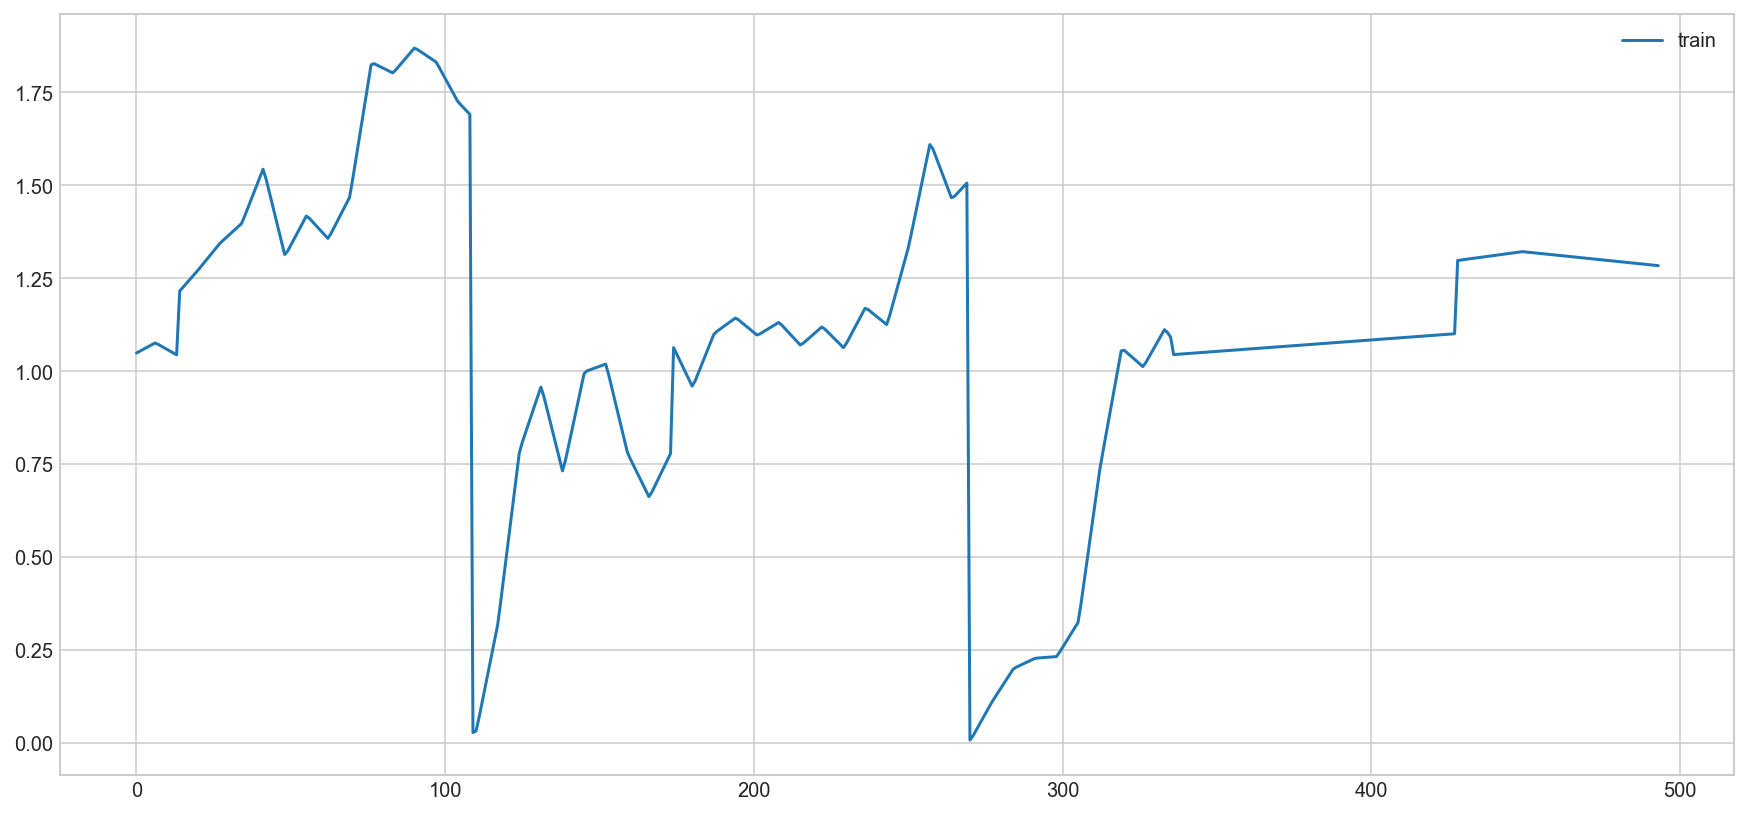

In [220]:
#plt.plot(y_true,label='true')
#plt.plot(y_test,label='test')
plt.plot(y_train,label='train')
plt.legend()

In [221]:
X_train = X_train.reshape((X_train.shape[0],1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0],1, X_test.shape[1]))

#y_train = y_train.reshape((1,y_train.shape[0]))
#y_test = y_test.reshape((1,y_test.shape[0]))

In [222]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Train on 494 samples, validate on 708 samples
Epoch 1/50
 - 1s - loss: 1.0463 - val_loss: nan
Epoch 2/50
 - 0s - loss: 0.5433 - val_loss: nan
Epoch 3/50
 - 0s - loss: 0.3590 - val_loss: nan
Epoch 4/50
 - 0s - loss: 0.3024 - val_loss: nan
Epoch 5/50
 - 0s - loss: 0.2714 - val_loss: nan
Epoch 6/50
 - 0s - loss: 0.2720 - val_loss: nan
Epoch 7/50
 - 0s - loss: 0.2625 - val_loss: nan
Epoch 8/50
 - 0s - loss: 0.2537 - val_loss: nan
Epoch 9/50
 - 0s - loss: 0.2484 - val_loss: nan
Epoch 10/50
 - 0s - loss: 0.2456 - val_loss: nan
Epoch 11/50
 - 0s - loss: 0.2411 - val_loss: nan
Epoch 12/50
 - 0s - loss: 0.2264 - val_loss: nan
Epoch 13/50
 - 0s - loss: 0.2235 - val_loss: nan
Epoch 14/50
 - 0s - loss: 0.2259 - val_loss: nan
Epoch 15/50
 - 0s - loss: 0.2164 - val_loss: nan
Epoch 16/50
 - 0s - loss: 0.2099 - val_loss: nan
Epoch 17/50
 - 0s - loss: 0.2067 - val_loss: nan
Epoch 18/50
 - 0s - loss: 0.2029 - val_loss: nan
Epoch 19/50
 - 0s - loss: 0.2027 - val_loss: nan
Epoch 20/50
 - 0s - loss: 0.1906

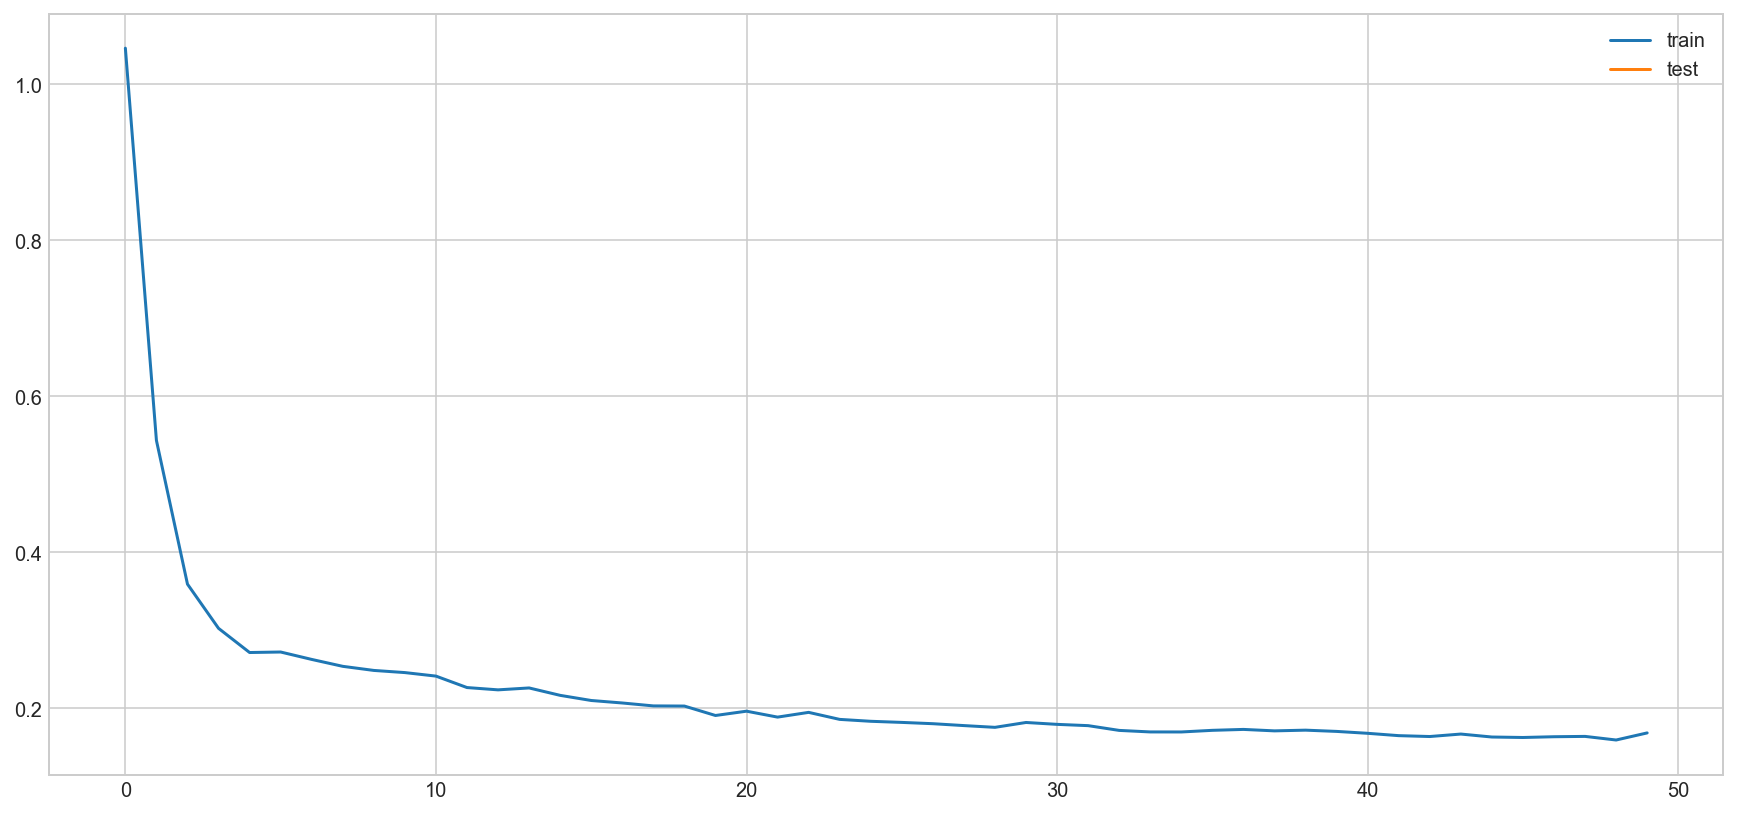

In [223]:
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=12, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [224]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(494, 1, 25) (708, 1, 25) (494,) (708,)


In [225]:
pred = model.predict(X_test).ravel()

In [226]:
pred_out[mask] = pred
pred_out[~mask] = np.nan
pred_out[pred_out < 0] = 0

In [227]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,pred_out.shape)

(494, 1, 25) (708, 1, 25) (494,) (708,) (730,)


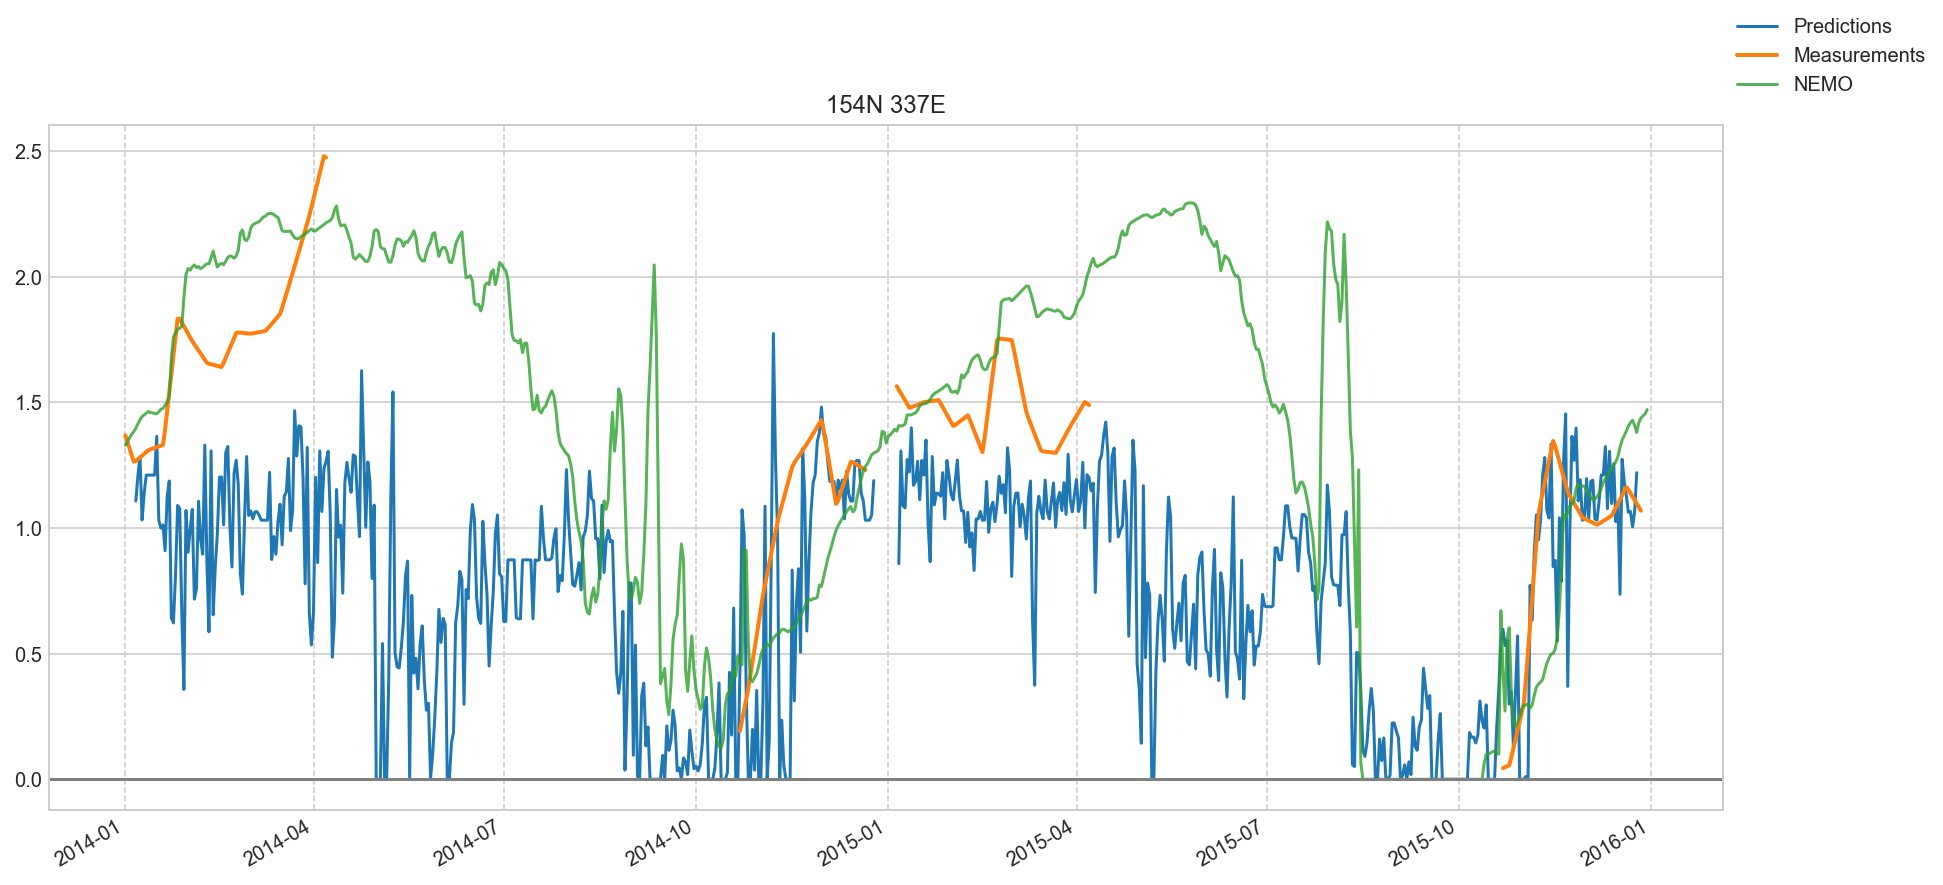

<module 'matplotlib.pyplot' from '/Users/drigo/anaconda3/envs/disser/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [228]:
plotting(pred_out, y_true, model_data, parameters['years_test'], title = '{}N {}E'.format(point[0], point[1]))